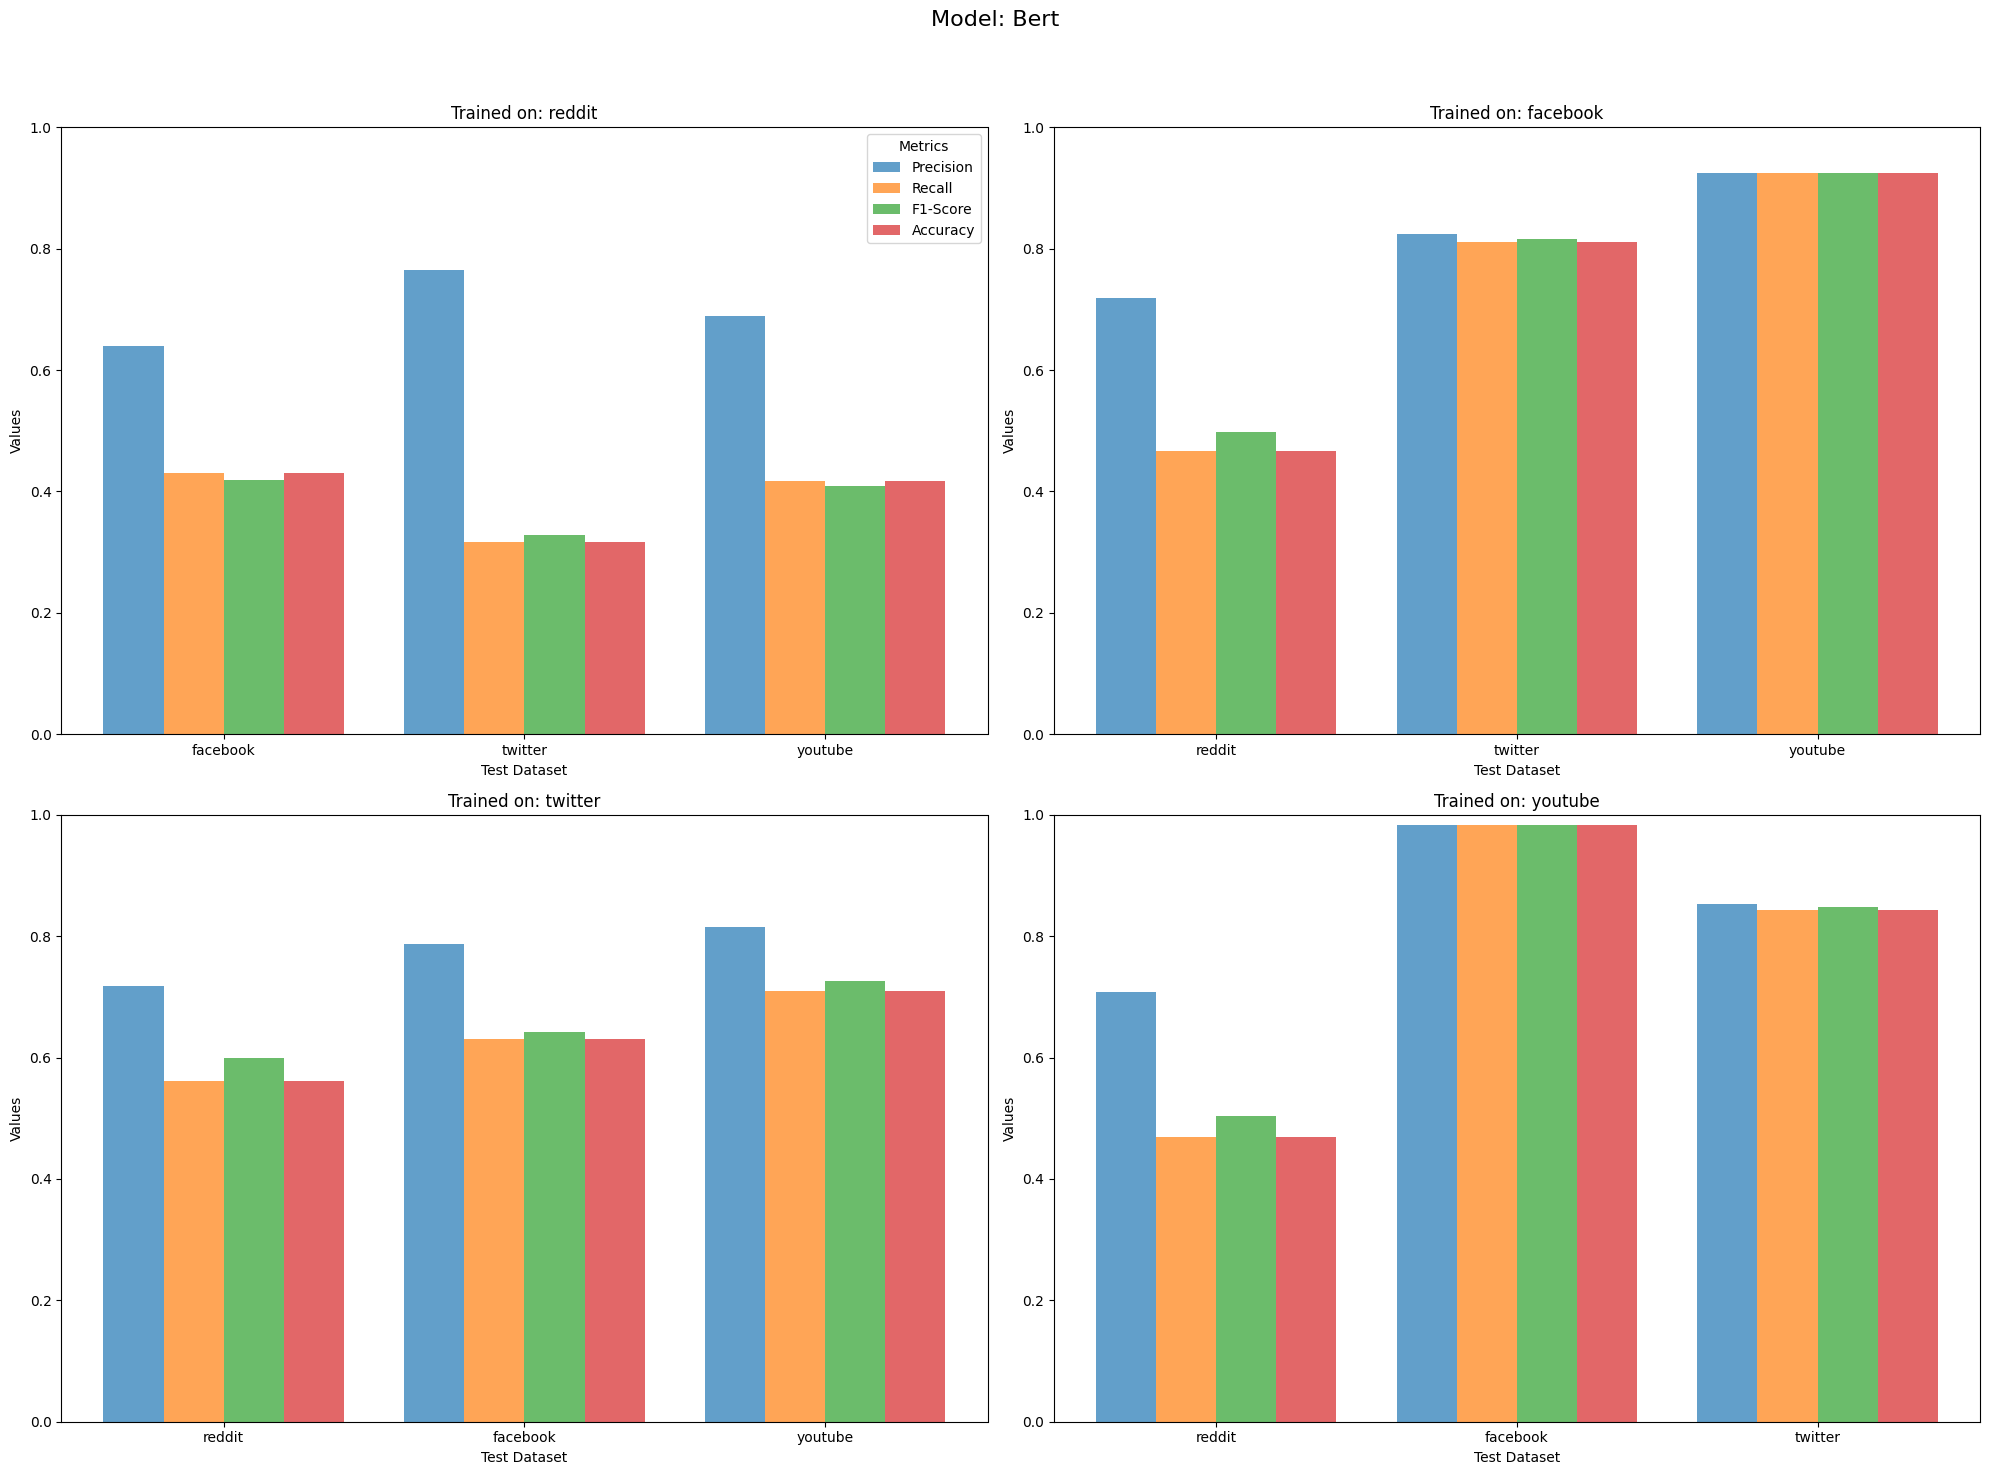

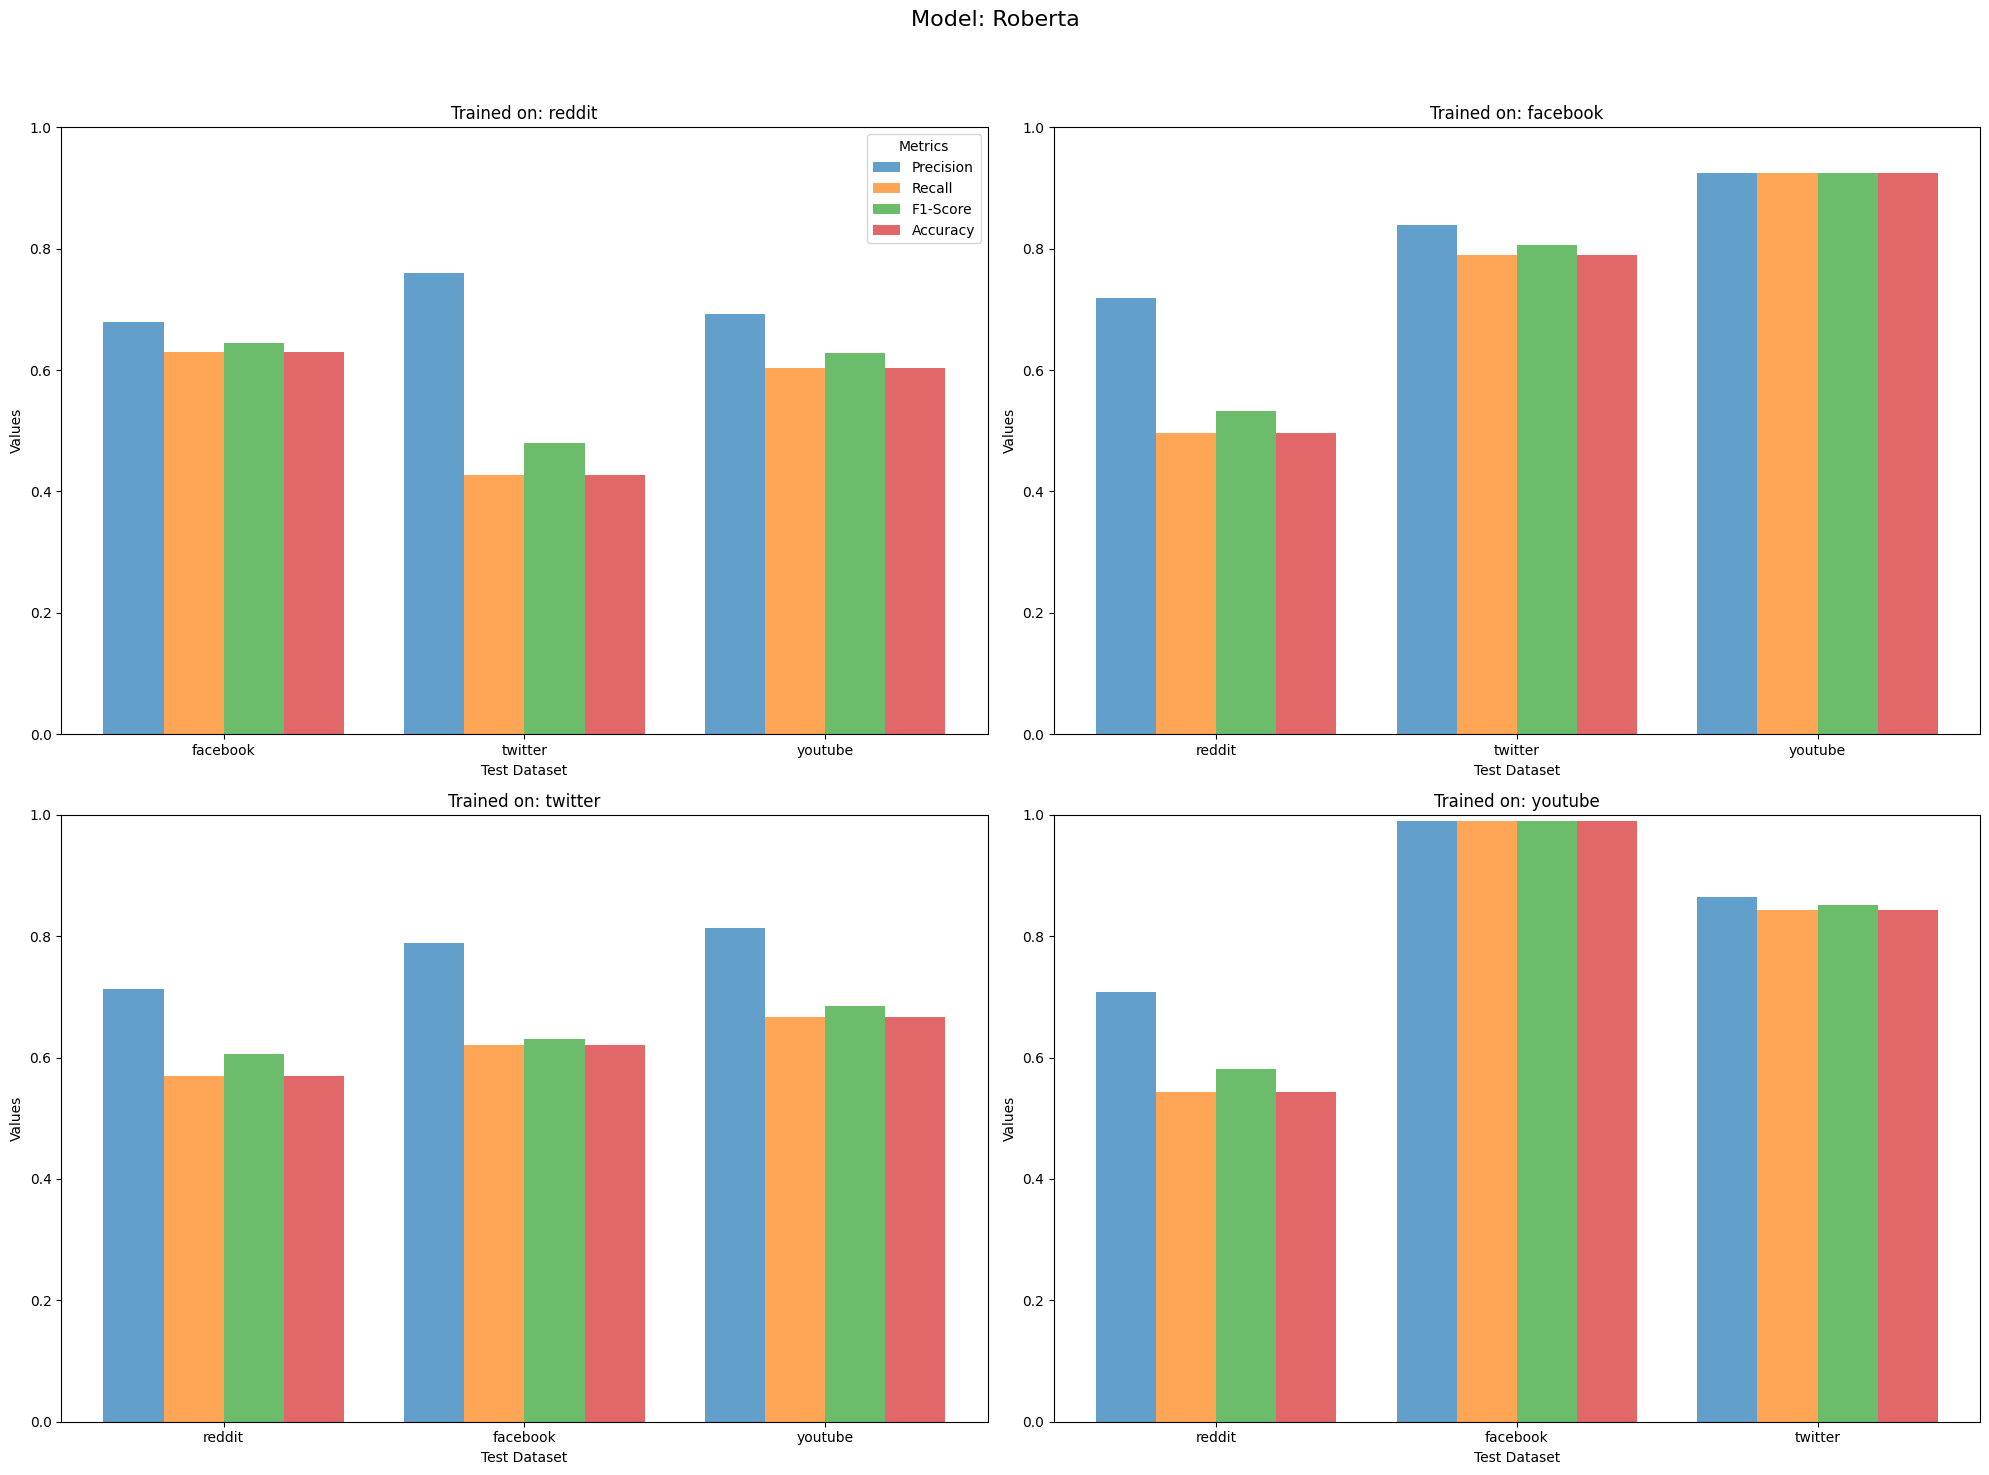

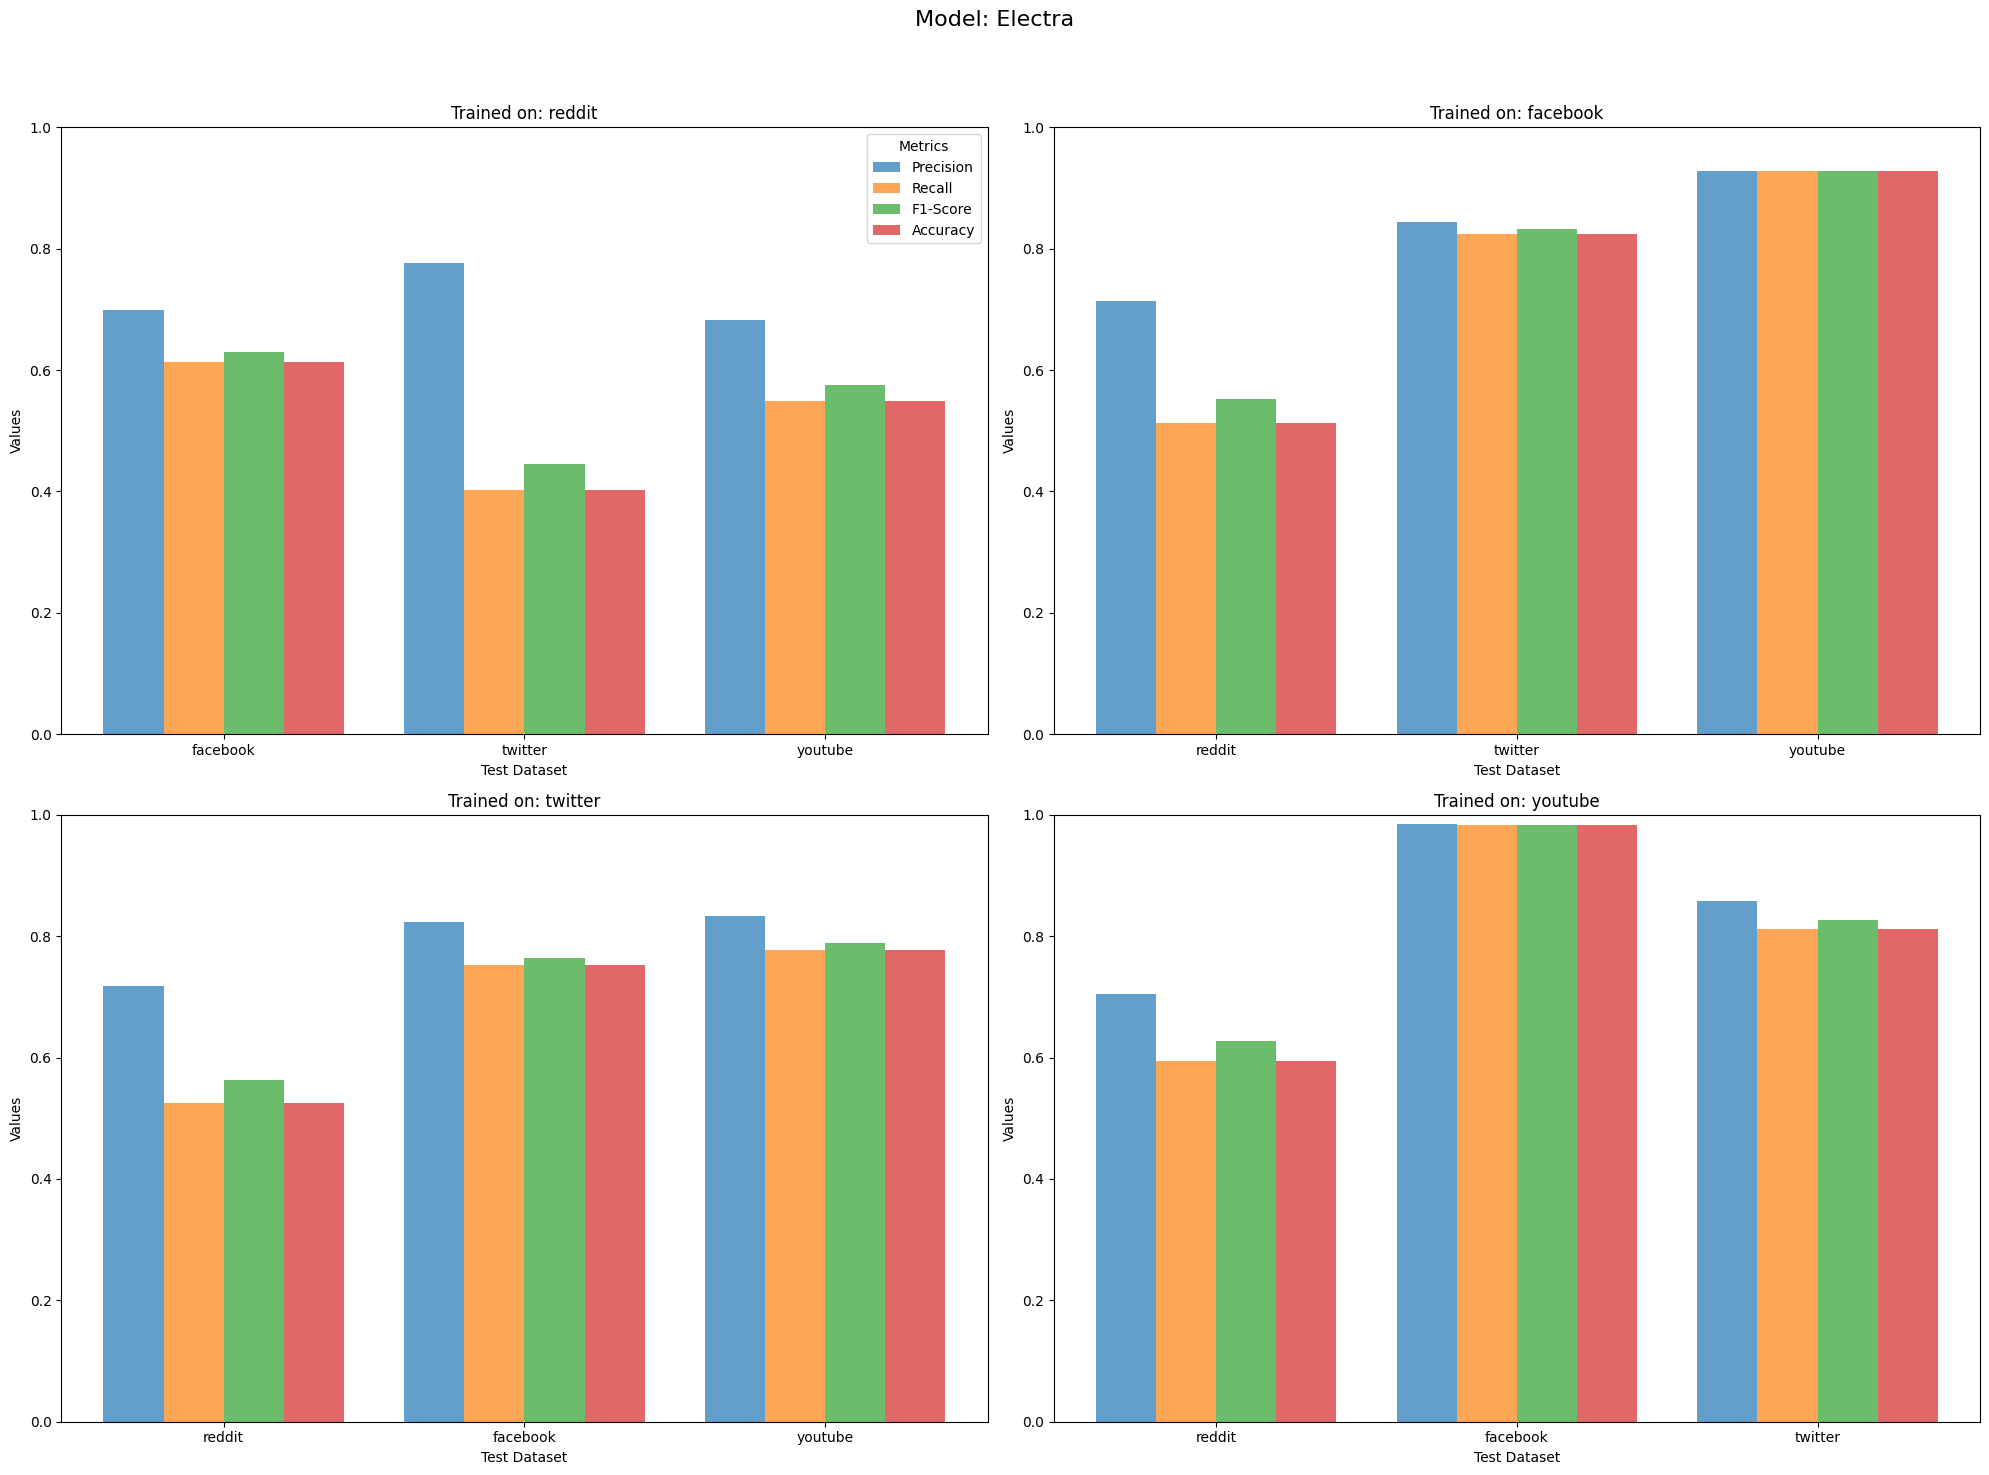

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

# List of models and social media datasets
models = ['Bert', 'Roberta', 'Electra']
platforms = ['reddit', 'facebook', 'twitter', 'youtube']

# Metrics to plot in the desired order
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Function to load and process CSV files for a given model and training dataset
def load_results(model, train_dataset):
    filename_pattern = f'{model.lower()}_results_{train_dataset}.csv'
    df = pd.read_csv(filename_pattern)

    # Standardize column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Initialize results dictionary
    results = {platform: [] for platform in platforms if platform != train_dataset}

    for column in results.keys():
        for index, row in df.iterrows():
            if row['unnamed: 0'] == 'weighted avg':
                metric_dict = json.loads(row[column].replace("'", "\""))
                results[column].append({
                    'Metric': 'Weighted Avg',
                    'Precision': metric_dict['precision'],
                    'Recall': metric_dict['recall'],
                    'F1-Score': metric_dict['f1-score']
                })
            elif row['unnamed: 0'] == 'accuracy':
                results[column].append({
                    'Metric': 'Accuracy',
                    'Accuracy': float(row[column])
                })
    return results

def plot_metrics(dataframes, model):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
    fig.suptitle(f'Model: {model}', fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for idx, (train_dataset, df) in enumerate(dataframes.items()):
        ax = axes[idx]

        # Create a DataFrame for plotting
        plot_data = []
        for test_dataset, metrics in df.items():
            for metric in metrics:
                # Ensure we are only handling dict-like structures
                if isinstance(metric, dict):
                    # Adding a 'Test Dataset' column for plotting
                    metric['Test Dataset'] = test_dataset
                    plot_data.append(metric)
        
        plot_df = pd.DataFrame(plot_data)

        # Define metrics to plot
        plot_metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

        # Define the width of each bar
        bar_width = 0.2

        # Create an array for the positions of each group of bars
        test_datasets = plot_df['Test Dataset'].unique()
        positions = np.arange(len(test_datasets))

        # Plot each metric
        for i, metric_name in enumerate(plot_metrics):
            if metric_name in plot_df.columns:
                # Select the data for the current metric
                if metric_name == 'Accuracy':
                    metric_values = [plot_df[(plot_df['Test Dataset'] == dataset) & (plot_df['Metric'] == 'Accuracy')]['Accuracy'].values[0]
                                     if not plot_df[(plot_df['Test Dataset'] == dataset) & (plot_df['Metric'] == 'Accuracy')]['Accuracy'].empty
                                     else 0
                                     for dataset in test_datasets]
                else:
                    metric_values = [plot_df[(plot_df['Test Dataset'] == dataset) & (plot_df['Metric'] == 'Weighted Avg')][metric_name].values[0]
                                     if not plot_df[(plot_df['Test Dataset'] == dataset) & (plot_df['Metric'] == 'Weighted Avg')][metric_name].empty
                                     else 0
                                     for dataset in test_datasets]
                ax.bar(positions + i * bar_width, metric_values, width=bar_width, label=metric_name, alpha=0.7)

        ax.set_xticks(positions + bar_width * (len(plot_metrics) - 1) / 2)
        ax.set_xticklabels(test_datasets)
        ax.set_xlabel('Test Dataset')
        ax.set_ylabel('Values')
        ax.set_ylim(0, 1)
        if idx == 0:
            ax.legend(loc='upper right', title='Metrics')

        ax.set_title(f'Trained on: {train_dataset}')

    # Adjust the layout
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure
    plt.savefig(f'{model}_combined_metrics.png')

    # Show the plots
    plt.show()

# Main logic to load data and plot for each model and training dataset
for model in models:
    dataframes = {train_dataset: load_results(model, train_dataset) for train_dataset in platforms}
    plot_metrics(dataframes, model)
